In [3]:
import networkx as nx
import pandas as pd
import numpy as np
from typing import List, Dict, Tuple
from matplotlib import pyplot as plt
import tqdm
import warnings
plt.style.use("ggplot")

In [4]:
g = nx.read_gml("../data/clean/all_routes.gml")

In [5]:
def get_nodes_by_type(g: nx.Graph, type:str) -> List[str]:
    return [city for city, typ in nx.get_node_attributes(g, "type").items() if typ == type]

def get_edges_by_type(g:nx.Graph, edge_type:str) -> List[Tuple[str, str]]:
    return [edge for edge, type in nx.get_edge_attributes(g, "type").items() if type == edge_type]

def get_neighbors_by_type(g:nx.Graph, location:str, type:str) -> List[str]:
    neighbors = []
    if type != "City" and type != "Airport" and type != "Station":
        raise ValueError(f"Unvalid type '{type}'")
    for node in g.adj[location]:
        if g.nodes[node]["type"] == type:
             neighbors.append(node) 
    return neighbors

def get_airplane_duration(g: nx.Graph, source_city:str, destination_city:str, airport_wait_minutes = 120) -> List[Dict[List[str], int]]:
    if source_city == destination_city:
        source_city.capitalize()
        destination_city.capitalize()
        warnings.warn("Source and destination city are the same")
        return 0
    assert g.has_node(source_city), f"{source_city} is not in network"
    assert g.has_node(destination_city), f"{destination_city} is not in network"

    source_airports = get_neighbors_by_type(g, source_city, type="Airport")
    destination_airports = get_neighbors_by_type(g, destination_city, type="Airport")
    possible_coombinations = [(source, destination)for source in source_airports for destination in destination_airports]

    durations = []
    for source_airport, destination_airport in possible_coombinations:
        route = {
            "nodes": [source_city, source_airport, destination_airport, destination_city],
            "duration": 0
        }
        route["duration"] += g[source_city][source_airport]["duration"]
        route["duration"] += g[source_airport][destination_airport]["duration"]
        route["duration"] += g[destination_airport][destination_city]["duration"]
        route["duration"] += airport_wait_minutes
        durations.append(route)
    return durations


def get_car_duration(g: nx.Graph, source_city:str, destination_city:str) -> List[Dict[List[str], int]]:
    if source_city == destination_city:
        source_city.capitalize()
        destination_city.capitalize()
        warnings.warn("Source and destination city are the same")
        return 0
    assert g.has_node(source_city), f"{source_city} is not in network"
    assert g.has_node(destination_city), f"{destination_city} is not in network"

    route = {
        "nodes": [source_city, destination_city],
        "duration": g[source_city][destination_city]["duration"]
    }
    
    return [route]

def get_train_duration(g: nx.Graph, source_city:str, destination_city:str, train_wait_minutes = 10) -> List[Dict[List[str], int]]:
    def filter_train_edges(n1, n2):
        type =  g[n1][n2].get("type", "none")
        return type == "train"
    
    if source_city == destination_city:
        source_city.capitalize()
        destination_city.capitalize()
        warnings.warn("Source and destination city are the same")
        return 0
        
    assert g.has_node(source_city), f"{source_city} is not in network"
    assert g.has_node(destination_city), f"{destination_city} is not in network"

    source_airports = get_neighbors_by_type(g, source_city, type="Station")
    destination_airports = get_neighbors_by_type(g, destination_city, type="Station")
    possible_coombinations = [(source, destination)for source in source_airports for destination in destination_airports]

    durations = []
    for source_station, destination_station in possible_coombinations:
        route = {
            "nodes": [source_city],
            "duration": 0
        }
        subgraph = nx.subgraph_view(g, filter_edge=filter_train_edges)
        shortest_path = nx.shortest_path(subgraph, source=source_station, target=destination_station, weight="duration")
        route["nodes"] += shortest_path + [destination_city]
        route["duration"] = nx.path_weight(g, shortest_path, "duration")
        route["duration"] += g[source_city][source_station]["duration"]
        route["duration"] += g[destination_city][destination_station]["duration"]
        durations.append(route)  
    return durations

In [22]:
def build_coombinations(l: List[str]):
    for i, node1 in enumerate(l):
        for j in range(i+1,len(l)):
                yield (l[i], l[j])


def get_durations_by_transport_type(g:nx.Graph, type:str, weight="duration")-> List[int]:
    # Get all car durations
    nodes = get_nodes_by_type(g, type)
    durations = []
    coombinations = build_coombinations(nodes)
    if type == "City" or "Airport":
        for source, dest in tqdm.tqdm(coombinations):
            durations.append(g[source][dest].get(weight, None))
    else:
        for source, dest in tqdm.tqdm(coombinations):
            try:
                durations.append(nx.shortest_path_length(g, source, dest, "duration"))
            except:
                pass
    return durations

g.remove_node("Split")
g.remove_node("Tirana")
g.remove_node("Lyon-St")

14878it [00:00, 1353112.77it/s]
14878it [00:00, 1190576.08it/s]
18145it [00:00, 1693230.83it/s]
18145it [00:00, 1684014.03it/s]


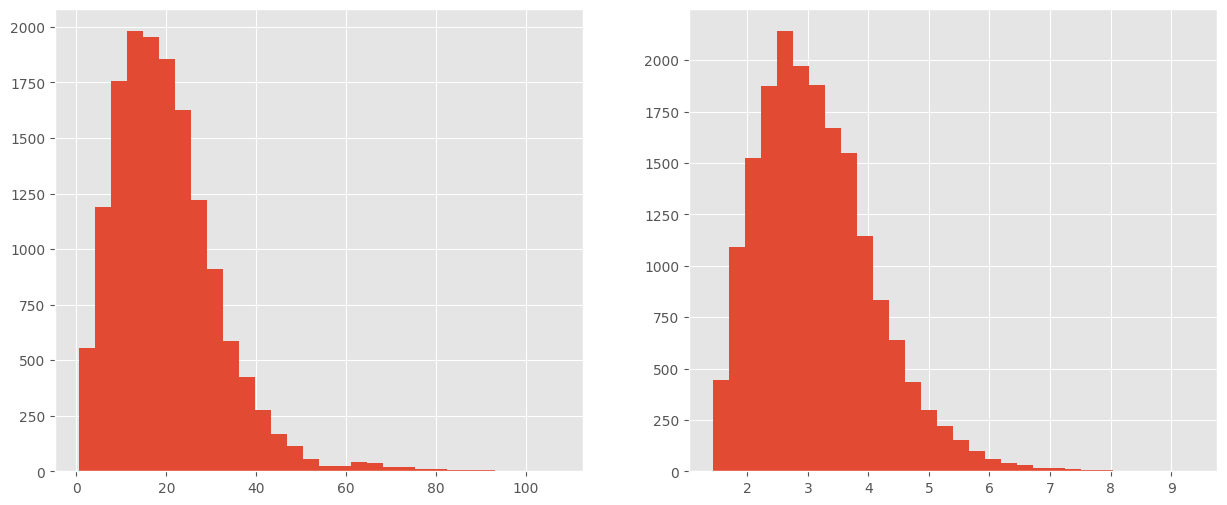

In [26]:
car_durations = get_durations_by_transport_type(g, "City")
car_distances = get_durations_by_transport_type(g, "City", weight="distance")

plane_durations = get_durations_by_transport_type(g, "Airport")
plane_distances = get_durations_by_transport_type(g, "Airport", weight="distance")


fig, ax = plt.subplots(1,2, figsize=(15,6))

ax[0].hist(np.array(car_durations) / 60, bins=30)
ax[1].hist(np.array(plane_durations) / 60, bins=30)

plt.show()

14878it [00:00, 1013115.59it/s]
14878it [00:00, 1095594.21it/s]
18145it [00:00, 1289401.70it/s]
18145it [00:00, 1248800.45it/s]


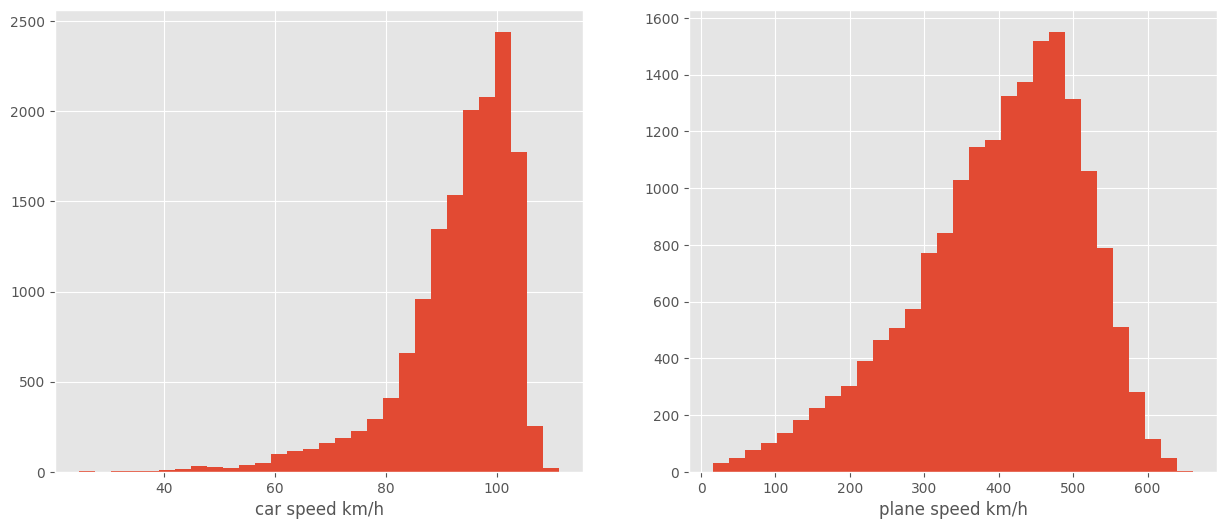

In [44]:
car_durations = get_durations_by_transport_type(g, "City")
car_distances = get_durations_by_transport_type(g, "City", weight="distance")

plane_durations = get_durations_by_transport_type(g, "Airport")
plane_distances = get_durations_by_transport_type(g, "Airport", weight="distance")


fig, ax = plt.subplots(1,2, figsize=(15,6))

ax[0].hist(np.array(car_distances) / np.array(car_durations) * 60, bins=30)
ax[1].hist(np.array(plane_distances) / np.array(plane_durations) * 60, bins=30)
ax[0].set_xlabel("car speed km/h")
ax[1].set_xlabel("plane speed km/h")
plt.show()

# Possible Questions
 - At what distance is it more efffective to travel by car/train than ride a plane?
 - What is the average speed of cars/planes
     - Are there any paths with a really low/high average speeds?
 - What are the distributions of car/plane/train durations
     - How much longer does it take to travel by train than car/train  
 - What are the longest routes in europe
 - What is the best way to travel from A to B (chose some locations)
 - What is the average distance from the city to the airport? Same for station to airport?
 - What is the average distance between airports in a country
 - What is the average travel time inside countries?